In [17]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from bokeh.plotting import figure, show, output_notebook
from bokeh.layouts import row
output_notebook()
import seaborn as sns

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA

from sklearn.linear_model.logistic import LogisticRegression

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

Loading BokehJS ...

In [45]:
def myAcp(df):
    
    sc = StandardScaler() 
    Z = sc.fit_transform(df)
    acp = PCA(svd_solver='full')
    coord = acp.fit_transform(Z) 
    
    taux = acp.explained_variance_ratio_ 
    taux = np.insert(taux,0,0)
    plt.plot(taux.cumsum())
    plt.grid(True)
    
    return pd.DataFrame(coord)

In [2]:
def traitement_types(df):
    df_ = df.copy().replace('\\N',np.NAN)
    
    for c in df_.columns:
        if 'crd_' in c or c in ['CRD','IMPAYES_DEBUT','age','adulte_foyer']:
            df_[c] = pd.to_numeric(df_[c], errors='coerce')
        
    df_.moy_eco_jour = df_.moy_eco_jour.str.replace(',', '.', regex=False).astype(float)
    df_.RAV_UC = df_.RAV_UC.str.replace(',', '.', regex=False).astype(float)
    
    df_['Date'] = pd.to_datetime(df_.year.astype(str) + '-' + df_.month.astype(str), format='%Y-%m')
    df_ = df_.drop(columns=['year','month'])
    
    return df_


def trancheAge(x):
    age = round(x.age)
    if age < 25:
        return '<25ans'

    elif age >= 25 and age <= 34:
        return  '25-34ans'

    elif age >= 35 and age <= 44:
        return  '35-44ans'

    elif age >= 45 and age <= 54:
        return  '45-54ans'

    elif age >= 55 and age <= 64:
        return  '55-64ans'

    elif age >= 65 and age <= 74:
        return  '65-74ans'

    elif age >= 75:
        return '>75ans'
    
    
def traitement_na(df):
    df_ = df.copy()
    
    df_ = df_.replace('Non Renseigne', np.NAN)
    for CRD in df_.columns.tolist():
        if 'crd_' in CRD:
            df_[CRD] = df_[CRD].fillna(0)
            
    
    # Catégoriser la PROFESSION selon la proximité des revenus
    revenus_prof = {}
    for p in df_.PROF.unique():
        REV = df_.loc[df_.PROF == p, 'REVENUS'].mean()
        try:
            revenus_prof[p] = round(REV)
        except:
            pass
    
    correct_PROF = df_.REVENUS.apply(lambda x: min(revenus_prof.items(), key=lambda v: abs(v[1] - int(x)))[1])
    df_['PROF'] = df_['PROF'].fillna(correct_PROF)
        
        
    
    # Catégoriser la cat_RAV_UC selon la proximité des Reste A Vivre Ouverture
    cat_RAV_ = {}
    for r in df_.cat_RAV_UC.unique():
        REV = df_.loc[df_.cat_RAV_UC == r, 'RAV_ouverture'].mean()
        try:
            cat_RAV_[r] = round(REV)
        except:
            pass
    
    correct_RAV = df_.RAV_ouverture.apply(lambda x: min(cat_RAV_.items(), key=lambda v: abs(v[1] - int(x)))[1])
    # NE MARCHE PAS ?
    #df_['cat_RAV_UC'] = df_['cat_RAV_UC'].fillna(cat_RAV_)
    df_['cat_RAV_UC'] = df_['cat_RAV_UC'].fillna('C')
    df_['RAV_UC'] = round(df_[df_.cat_RAV_UC == 'C'].RAV_UC.mean())
    
    
    
        
    for p in df_.PROF.unique():
        med = df_.loc[df_.PROF == p].age.median()
        df_.loc[df_.PROF == p, 'age'] = df_.loc[df_.PROF == p, 'age'].fillna(med)
    
    # Tranche d'age en fonction de l'age précedement calculé
    df_.tranche_age = df_.apply(lambda x: trancheAge(x), axis=1)
    
    
    # Il y a 60% de '2' dans adulte foyer
    df_.adulte_foyer = df_.adulte_foyer.fillna(2)
    # Peu important 
    df_.situation = df_.situation.fillna('autre')
    # Trop de cas pssibles, malgrès une majorité (50%) d' Endettement 
    df_.NATURE_DIFF = df_.NATURE_DIFF.fillna('autre')
    # Peu important 
    df_.region = df_.region.fillna('inconnu')
    # Peu important 
    df_.cat_moy_eco_jour = df_.cat_moy_eco_jour.fillna('inconnu')
    # Majorité
    df_.LOGEMENT = df_.LOGEMENT.fillna('locataire')
    # NA environ 0 
    df_.moy_eco_jour = df_.moy_eco_jour.fillna(0)
    # Valeur majoritaire
    df_.cat_credit = df_.cat_credit.fillna('1€-499€')
    # Valeur medianne
    df_.CRD = df_.CRD.fillna(df_.CRD.median())
    
    
    # Colonnes peu exploitables
    df_ = df_.drop(columns=['IMPAYES_DEBUT','STRUCTURE PRESCRIPTRICE'])
    
    df_.gain_mediation = df_.gain_mediation.fillna(0).astype(int)
    
    df_.cat_impayes = df_.cat_impayes.fillna('Inconnu')
    
    #df_ = df_.dropna()
    
    return df_

In [3]:
def mega_traitement(df,dummies=False):
    df_ = df.copy()
    df_ = traitement_types(df_)
    df_ = traitement_na(df_)

    ## ?? A RETIRER ?? ##
    for cc in list(df_.dtypes[df_.dtypes == 'object'].to_dict().keys()):
        #print(cc)
        cat_dtype = pd.api.types.CategoricalDtype(categories=df_[cc].unique().tolist(), ordered=False)
        df_[cc] = df_[cc].astype(cat_dtype)
    # # # # # # # # # # #
    
    if dummies:
        or_dummies = pd.get_dummies(df_.ORIENTATION)
        df_[df_.ORIENTATION.unique().tolist()]=or_dummies
    
    for cat in list(df_.dtypes[df_.dtypes == 'category'].to_dict().keys()):
        gle = LabelEncoder()
        #print(cat)
        df_[cat] = gle.fit_transform(df_[cat].astype(str))
    
    return df_


In [4]:
train = pd.read_csv('../data/train.csv')
train = mega_traitement(train,dummies=False)
train.head()

,id,PLATEFORME,region,ORIENTATION,NATURE_DIFF,age,tranche_age,situation,adulte_foyer,pers_a_charge,...,crd_immo,nb_rac,crd_rac,nb_autres,crd_autres,nb_decouvert,crd_decouvert,moy_eco_jour,cat_moy_eco_jour,Date
0,1550,0,2,5,18,68.0,4,1,1.0,0,...,0.0,0,0.0,0,0.0,0,0.0,2.53333,0,2015-07-01
1,2249,0,13,3,5,68.0,4,4,2.0,0,...,0.0,0,0.0,0,0.0,0,0.0,-3.31667,5,2016-02-01
2,2670,1,15,0,5,45.0,2,1,1.0,0,...,0.0,0,0.0,1,3996.0,0,0.0,-24.76670,5,2016-04-01
3,1102,0,3,3,10,68.0,4,3,1.0,0,...,0.0,0,0.0,0,0.0,0,0.0,29.56670,2,2014-11-01
4,7069,1,12,0,4,24.0,5,2,2.0,0,...,0.0,0,0.0,0,0.0,0,0.0,-19.15000,5,2018-09-01


/Users/william/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/william/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


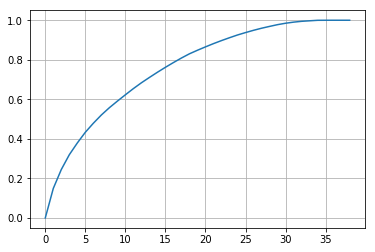

In [56]:
or_dummies = list(train.columns[-6:])
to_drop = ['Date','id'] #+ or_dummies

X = train.drop(columns=to_drop +['ORIENTATION'])
y = train[['ORIENTATION']]


# Sélection de features probablement utiles
to_use =['CRD','REVENUS','CHARGES','CREDITS','moy_eco_jour','RAV_ouverture', 'crd_renouv', 'crd_amort']


#__X = X[to_use]
__X = myAcp(X)

X_train, X_test, y_train, y_test = train_test_split(__X, y, test_size=0.2, random_state=42)

In [57]:
LogReg = LogisticRegression(solver='newton-cg', multi_class='multinomial', random_state=42)

LogReg.fit(X_train,y_train)

/Users/william/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=42, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [58]:
resultats = pd.DataFrame({'label':LogReg.predict(X_test)})
resultats['ORIENTATION'] = y_test['ORIENTATION'].values

pd.DataFrame(resultats.ORIENTATION == resultats.label).sum()/resultats.shape[0]

0    0.563953
dtype: float64

In [65]:
LogReg.score(X_test,y_test)

0.563953488372093

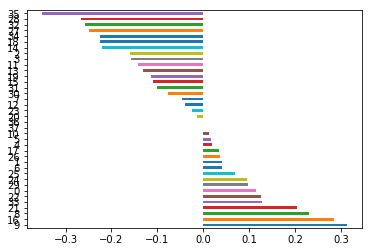

In [62]:
(pd.Series(LogReg.coef_[0], index=X_train.columns)
   .nlargest(38)
   .plot(kind='barh'))

In [25]:
LogReg.coef_

array([[ 7.29858258e-02, -9.19363436e-03, -3.86177805e-02,
        -6.46622181e-03, -1.57125640e-02, -1.96733891e-02,
         5.39933411e-03, -1.59586960e-02,  1.45262589e-03,
         2.21474564e-02,  2.59074056e-04,  1.00142474e-02,
         1.10386940e-05,  1.10327779e-02,  2.33313025e-05,
        -2.36547448e-02, -7.53911255e-02,  2.24704059e-04,
        -1.01402437e-01, -3.51055863e-03, -8.08160042e-02,
        -7.87661594e-02, -1.40967795e-05, -2.53428454e-03,
        -1.24552950e-02,  1.07403931e-05, -9.59656888e-02,
         1.66281607e-05,  9.47226702e-03,  1.36971506e-05,
         1.59198758e-03,  1.42018596e-05,  2.93483297e-04,
         8.07711967e-07,  1.37776445e-02, -3.75541758e-05,
         5.51555310e-03,  8.06463901e-03],
       [-2.58886433e-02,  4.79226916e-02,  9.83857846e-02,
        -1.49028799e-02,  5.69270870e-03, -2.21961481e-02,
        -9.48696675e-04, -2.86108284e-02,  4.33733380e-02,
         3.90822141e-04, -1.50959478e-04,  9.77578544e-02,
         6.62